In [1]:
import pandas as pd 
import os

In [2]:
repeat0 = 20
repeat1 = 4000

In [3]:
code = r"""

; ------------------------------------
; Author: Hosein Yavarzadeh 
; Email: hyavarzadeh@ucsd.edu
; Supervisor: Prof. Dean Tullsen
; ------------------------------------

%define repeat0  20             ; Number of repetitions of whole test. Default = 8
%define repeat1  4000           ; Repeat count for loop around testcode. Default = no loop
%define repeat2  1              ; Repeat count for repeat macro around testcode. Default = 100

%macro testinitc 0              ; Macro to call in each test before reading counters.
    mov dword[PrintCustomPMC], 1
    mov ebx, 8000             
    lea rdi, [UserData]
    rand_loop:
    rdrand eax
    and eax, 1
    mov [rdi], al
    inc rdi
    dec ebx
    jnz rand_loop

%endmacro

%macro testinit2 0              ; Macro with initializations before each test. Default = nothing
    lea rdi, [UserData]
%endmacro

%macro testcode 0               ; A multi-line macro executing any piece of test code.

    inc rdi

    cmp byte[rdi],0
    
    ; dummy_branch 300, 0

    ; jmp rand_branch
    mov rax, 0x100000000
    mov rbx, rand_branch_back
    mov rdx, 200
    mov rcx, 0
    cmp rcx, 0
    jmp rax
    rand_branch_back:

    dummy_branch var, 5

    ; test branch
    READ_PMC_START
    cmp byte[rdi],0
    je target2
    target2:
    READ_PMC_END

%endmacro

%macro dummy_branch 2
      mov rax, 0
      %assign i (100)*(%2)
      %assign j (100)*(%2)
      %rep %1
            %assign j i+1
            label%+ i:
            cmp rax, 0
            je label%+ j 
            %assign i j  
      %endrep
    ;   align (1 << my_align)
      label%+ j:
%endmacro

"""

In [4]:
ld_script = r"""
/* Script for -z combreloc -z separate-code */
/* Copyright (C) 2014-2020 Free Software Foundation, Inc.
   Copying and distribution of this script, with or without modification,
   are permitted in any medium without royalty provided the copyright
   notice and this notice are preserved.  */
OUTPUT_FORMAT("elf64-x86-64", "elf64-x86-64",
	      "elf64-x86-64")
OUTPUT_ARCH(i386:x86-64)
ENTRY(_start)
SEARCH_DIR("=/usr/local/lib/x86_64-linux-gnu"); SEARCH_DIR("=/lib/x86_64-linux-gnu"); SEARCH_DIR("=/usr/lib/x86_64-linux-gnu"); SEARCH_DIR("=/usr/lib/x86_64-linux-gnu64"); SEARCH_DIR("=/usr/local/lib64"); SEARCH_DIR("=/lib64"); SEARCH_DIR("=/usr/lib64"); SEARCH_DIR("=/usr/local/lib"); SEARCH_DIR("=/lib"); SEARCH_DIR("=/usr/lib"); SEARCH_DIR("=/usr/x86_64-linux-gnu/lib64"); SEARCH_DIR("=/usr/x86_64-linux-gnu/lib");
SECTIONS
{
  PROVIDE (__executable_start = SEGMENT_START("text-segment", 0x400000)); . = SEGMENT_START("text-segment", 0x400000) + SIZEOF_HEADERS;
  .interp         : { *(.interp) }
  .note.gnu.build-id  : { *(.note.gnu.build-id) }
  .hash           : { *(.hash) }
  .gnu.hash       : { *(.gnu.hash) }
  .dynsym         : { *(.dynsym) }
  .dynstr         : { *(.dynstr) }
  .gnu.version    : { *(.gnu.version) }
  .gnu.version_d  : { *(.gnu.version_d) }
  .gnu.version_r  : { *(.gnu.version_r) }
  .rela.dyn       :
    {
      *(.rela.init)
      *(.rela.text .rela.text.* .rela.gnu.linkonce.t.*)
      *(.rela.fini)
      *(.rela.rodata .rela.rodata.* .rela.gnu.linkonce.r.*)
      *(.rela.data .rela.data.* .rela.gnu.linkonce.d.*)
      *(.rela.tdata .rela.tdata.* .rela.gnu.linkonce.td.*)
      *(.rela.tbss .rela.tbss.* .rela.gnu.linkonce.tb.*)
      *(.rela.ctors)
      *(.rela.dtors)
      *(.rela.got)
      *(.rela.bss .rela.bss.* .rela.gnu.linkonce.b.*)
      *(.rela.ldata .rela.ldata.* .rela.gnu.linkonce.l.*)
      *(.rela.lbss .rela.lbss.* .rela.gnu.linkonce.lb.*)
      *(.rela.lrodata .rela.lrodata.* .rela.gnu.linkonce.lr.*)
      *(.rela.ifunc)
    }
  .rela.plt       :
    {
      *(.rela.plt)
      PROVIDE_HIDDEN (__rela_iplt_start = .);
      *(.rela.iplt)
      PROVIDE_HIDDEN (__rela_iplt_end = .);
    }
  . = ALIGN(CONSTANT (MAXPAGESIZE));
  .init           :
  {
    KEEP (*(SORT_NONE(.init)))
  }
  .plt            : { *(.plt) *(.iplt) }
.plt.got        : { *(.plt.got) }
.plt.sec        : { *(.plt.sec) }
  . = 0x40000000;
  .text           :
  {
    b64.o (.text .stub .text.* .gnu.linkonce.t.*)
    *(.text.unlikely .text.*_unlikely .text.unlikely.*)
    *(.text.exit .text.exit.*)
    *(.text.startup .text.startup.*)
    *(.text.hot .text.hot.*)
    *(SORT(.text.sorted.*))
    a64.o (.text .stub .text.* .gnu.linkonce.t.*)
    /* .gnu.warning sections are handled specially by elf.em.  */
    *(.gnu.warning)
  }
  .fini           :
  {
    KEEP (*(SORT_NONE(.fini)))
  }
  PROVIDE (__etext = .);
  PROVIDE (_etext = .);
  PROVIDE (etext = .);
  . = ALIGN(CONSTANT (MAXPAGESIZE));
  /* Adjust the address for the rodata segment.  We want to adjust up to
     the same address within the page on the next page up.  */
  . = SEGMENT_START("rodata-segment", ALIGN(CONSTANT (MAXPAGESIZE)) + (. & (CONSTANT (MAXPAGESIZE) - 1)));
  .rodata         : { *(.rodata .rodata.* .gnu.linkonce.r.*) }
  .rodata1        : { *(.rodata1) }
  .eh_frame_hdr   : { *(.eh_frame_hdr) *(.eh_frame_entry .eh_frame_entry.*) }
  .eh_frame       : ONLY_IF_RO { KEEP (*(.eh_frame)) *(.eh_frame.*) }
  .gcc_except_table   : ONLY_IF_RO { *(.gcc_except_table .gcc_except_table.*) }
  .gnu_extab   : ONLY_IF_RO { *(.gnu_extab*) }
  /* These sections are generated by the Sun/Oracle C++ compiler.  */
  .exception_ranges   : ONLY_IF_RO { *(.exception_ranges*) }
  /* Adjust the address for the data segment.  We want to adjust up to
     the same address within the page on the next page up.  */
  . = DATA_SEGMENT_ALIGN (CONSTANT (MAXPAGESIZE), CONSTANT (COMMONPAGESIZE));
  /* Exception handling  */
  .eh_frame       : ONLY_IF_RW { KEEP (*(.eh_frame)) *(.eh_frame.*) }
  .gnu_extab      : ONLY_IF_RW { *(.gnu_extab) }
  .gcc_except_table   : ONLY_IF_RW { *(.gcc_except_table .gcc_except_table.*) }
  .exception_ranges   : ONLY_IF_RW { *(.exception_ranges*) }
  /* Thread Local Storage sections  */
  .tdata	  :
   {
     PROVIDE_HIDDEN (__tdata_start = .);
     *(.tdata .tdata.* .gnu.linkonce.td.*)
   }
  .tbss		  : { *(.tbss .tbss.* .gnu.linkonce.tb.*) *(.tcommon) }
  .preinit_array    :
  {
    PROVIDE_HIDDEN (__preinit_array_start = .);
    KEEP (*(.preinit_array))
    PROVIDE_HIDDEN (__preinit_array_end = .);
  }
  .init_array    :
  {
    PROVIDE_HIDDEN (__init_array_start = .);
    KEEP (*(SORT_BY_INIT_PRIORITY(.init_array.*) SORT_BY_INIT_PRIORITY(.ctors.*)))
    KEEP (*(.init_array EXCLUDE_FILE (*crtbegin.o *crtbegin?.o *crtend.o *crtend?.o ) .ctors))
    PROVIDE_HIDDEN (__init_array_end = .);
  }
  .fini_array    :
  {
    PROVIDE_HIDDEN (__fini_array_start = .);
    KEEP (*(SORT_BY_INIT_PRIORITY(.fini_array.*) SORT_BY_INIT_PRIORITY(.dtors.*)))
    KEEP (*(.fini_array EXCLUDE_FILE (*crtbegin.o *crtbegin?.o *crtend.o *crtend?.o ) .dtors))
    PROVIDE_HIDDEN (__fini_array_end = .);
  }
  .ctors          :
  {
    /* gcc uses crtbegin.o to find the start of
       the constructors, so we make sure it is
       first.  Because this is a wildcard, it
       doesn't matter if the user does not
       actually link against crtbegin.o; the
       linker won't look for a file to match a
       wildcard.  The wildcard also means that it
       doesn't matter which directory crtbegin.o
       is in.  */
    KEEP (*crtbegin.o(.ctors))
    KEEP (*crtbegin?.o(.ctors))
    /* We don't want to include the .ctor section from
       the crtend.o file until after the sorted ctors.
       The .ctor section from the crtend file contains the
       end of ctors marker and it must be last */
    KEEP (*(EXCLUDE_FILE (*crtend.o *crtend?.o ) .ctors))
    KEEP (*(SORT(.ctors.*)))
    KEEP (*(.ctors))
  }
  .dtors          :
  {
    KEEP (*crtbegin.o(.dtors))
    KEEP (*crtbegin?.o(.dtors))
    KEEP (*(EXCLUDE_FILE (*crtend.o *crtend?.o ) .dtors))
    KEEP (*(SORT(.dtors.*)))
    KEEP (*(.dtors))
  }
  .jcr            : { KEEP (*(.jcr)) }
  .data.rel.ro : { *(.data.rel.ro.local* .gnu.linkonce.d.rel.ro.local.*) *(.data.rel.ro .data.rel.ro.* .gnu.linkonce.d.rel.ro.*) }
  .dynamic        : { *(.dynamic) }
  .got            : { *(.got) *(.igot) }
  . = DATA_SEGMENT_RELRO_END (SIZEOF (.got.plt) >= 24 ? 24 : 0, .);
  .got.plt        : { *(.got.plt) *(.igot.plt) }
  .data           :
  {
    *(.data .data.* .gnu.linkonce.d.*)
    SORT(CONSTRUCTORS)
  }
  .data1          : { *(.data1) }
  _edata = .; PROVIDE (edata = .);
  . = .;
  __bss_start = .;
  .bss            :
  {
   *(.dynbss)
   *(.bss .bss.* .gnu.linkonce.b.*)
   *(COMMON)
   /* Align here to ensure that the .bss section occupies space up to
      _end.  Align after .bss to ensure correct alignment even if the
      .bss section disappears because there are no input sections.
      FIXME: Why do we need it? When there is no .bss section, we do not
      pad the .data section.  */
   . = ALIGN(. != 0 ? 64 / 8 : 1);
  }
  .lbss   :
  {
    *(.dynlbss)
    *(.lbss .lbss.* .gnu.linkonce.lb.*)
    *(LARGE_COMMON)
  }
  . = ALIGN(64 / 8);
  . = SEGMENT_START("ldata-segment", .);
  .lrodata   ALIGN(CONSTANT (MAXPAGESIZE)) + (. & (CONSTANT (MAXPAGESIZE) - 1)) :
  {
    *(.lrodata .lrodata.* .gnu.linkonce.lr.*)
  }
  .ldata   ALIGN(CONSTANT (MAXPAGESIZE)) + (. & (CONSTANT (MAXPAGESIZE) - 1)) :
  {
    *(.ldata .ldata.* .gnu.linkonce.l.*)
    . = ALIGN(. != 0 ? 64 / 8 : 1);
  }
  . = ALIGN(64 / 8);
  _end = .; PROVIDE (end = .);
  . = DATA_SEGMENT_END (.);
  /* Stabs debugging sections.  */
  .stab          0 : { *(.stab) }
  .stabstr       0 : { *(.stabstr) }
  .stab.excl     0 : { *(.stab.excl) }
  .stab.exclstr  0 : { *(.stab.exclstr) }
  .stab.index    0 : { *(.stab.index) }
  .stab.indexstr 0 : { *(.stab.indexstr) }
  .comment       0 : { *(.comment) }
  .gnu.build.attributes : { *(.gnu.build.attributes .gnu.build.attributes.*) }
  /* DWARF debug sections.
     Symbols in the DWARF debugging sections are relative to the beginning
     of the section so we begin them at 0.  */
  /* DWARF 1 */
  .debug          0 : { *(.debug) }
  .line           0 : { *(.line) }
  /* GNU DWARF 1 extensions */
  .debug_srcinfo  0 : { *(.debug_srcinfo) }
  .debug_sfnames  0 : { *(.debug_sfnames) }
  /* DWARF 1.1 and DWARF 2 */
  .debug_aranges  0 : { *(.debug_aranges) }
  .debug_pubnames 0 : { *(.debug_pubnames) }
  /* DWARF 2 */
  .debug_info     0 : { *(.debug_info .gnu.linkonce.wi.*) }
  .debug_abbrev   0 : { *(.debug_abbrev) }
  .debug_line     0 : { *(.debug_line .debug_line.* .debug_line_end) }
  .debug_frame    0 : { *(.debug_frame) }
  .debug_str      0 : { *(.debug_str) }
  .debug_loc      0 : { *(.debug_loc) }
  .debug_macinfo  0 : { *(.debug_macinfo) }
  /* SGI/MIPS DWARF 2 extensions */
  .debug_weaknames 0 : { *(.debug_weaknames) }
  .debug_funcnames 0 : { *(.debug_funcnames) }
  .debug_typenames 0 : { *(.debug_typenames) }
  .debug_varnames  0 : { *(.debug_varnames) }
  /* DWARF 3 */
  .debug_pubtypes 0 : { *(.debug_pubtypes) }
  .debug_ranges   0 : { *(.debug_ranges) }
  /* DWARF Extension.  */
  .debug_macro    0 : { *(.debug_macro) }
  .debug_addr     0 : { *(.debug_addr) }
  .gnu.attributes 0 : { KEEP (*(.gnu.attributes)) }
  /DISCARD/ : { *(.note.GNU-stack) *(.gnu_debuglink) *(.gnu.lto_*) }

"""

In [5]:
def create_nasm(cnt):
    nasm_new_sections = ''
    for i in range(cnt):
        nasm_new_sections += f"""
SECTION .dummy_branch_{i} exec
    dummy_label_{i}:
    je dummy_label_{i+1}

"""
    nasm_new_sections += f"""
SECTION .dummy_branch_{cnt} exec
    dummy_label_{cnt}:
    dec rdx
    cmp rdx, 0
    jmp dummy_label_{cnt+1}

SECTION .dummy_branch_{cnt+1} exec
    dummy_label_{cnt+1}:
    je dummy_label_{cnt+2}
    mov rax, 0x100000000
    mov rcx, 0
    cmp rcx, 0
    jmp rax

SECTION .dummy_branch_{cnt+2} exec
    dummy_label_{cnt+2}:
    cmp byte[rdi],0
    jmp dummy_label_{cnt+3}

SECTION .dummy_branch_{cnt+3} exec
    dummy_label_{cnt+3}:
    je dummy_label_{cnt+4}
    jmp dummy_label_{cnt+4}

SECTION .dummy_branch_{cnt+4} exec
    dummy_label_{cnt+4}:
    jmp rbx
"""
    with open("bp.nasm", "w") as file:
      file.write(code + nasm_new_sections)

In [6]:
def create_ld(a, b, cnt, stride=0x10000000):
  ld_new_sections = ''

  for i in range(cnt):
    ld_new_sections += f"""
    . = {hex(0x100000000 + i * stride)};
    .dummy_branch_{i} : {{ *(.dummy_branch_{i}) }}
  """

  ld_new_sections += f"""
    . = {hex(0x100000000 + cnt * stride + ((1 << a) if a >= 0 else 0))};
    .dummy_branch_{cnt} : {{ *(.dummy_branch_{cnt}) }}
  """

  ld_new_sections += f"""
    . = {hex(0x100000000 + (cnt + 1) * stride + ((b << b) if a >= 0 else 0))};
    .dummy_branch_{cnt + 1} : {{ *(.dummy_branch_{cnt + 1}) }}
  """

  ld_new_sections += '}'

  with open("script.ld", "w") as file:
      file.write(ld_script + ld_new_sections)

In [7]:
# rdx 5
cnt = 10
start = 0
end = 10

final_dfs = []
for i in range(6,32):
    final_df = pd.DataFrame()
    for j in range(-1,0):
        create_nasm(cnt)
        create_ld(-1, j, cnt + 3, 1 << i)
        print(i, j)
        os.system(f"./run.sh {i} {j} {start} {end}")

        data = pd.read_csv("results.csv", comment='#', delim_whitespace=True)
        data["Clock"] = pd.to_numeric(data["Clock"],errors='coerce')
        data["BrRetired"] = pd.to_numeric(data["BrRetired"],errors='coerce')
        data["BrMispred"] = pd.to_numeric(data["BrMispred"],errors='coerce')
        data["Clock"] = (data["Clock"]) / repeat1
        data["BrRetired"] = data["BrRetired"] / repeat1
        data["BrMispred"] = data["BrMispred"] / repeat1
        final_df[j] = data.groupby(data.index // repeat0).mean()["BrMispred"]
    final_dfs.append(final_df)

6 -1
Experiment date and time: Tue 30 Jan 2024 04:23:36 PM EST


7 -1
Experiment date and time: Tue 30 Jan 2024 04:23:43 PM EST
8 -1
Experiment date and time: Tue 30 Jan 2024 04:23:50 PM EST
9 -1
Experiment date and time: Tue 30 Jan 2024 04:23:57 PM EST
10 -1
Experiment date and time: Tue 30 Jan 2024 04:24:04 PM EST
11 -1
Experiment date and time: Tue 30 Jan 2024 04:24:10 PM EST
12 -1
Experiment date and time: Tue 30 Jan 2024 04:24:17 PM EST
13 -1
Experiment date and time: Tue 30 Jan 2024 04:24:25 PM EST
14 -1
Experiment date and time: Tue 30 Jan 2024 04:24:33 PM EST
15 -1
Experiment date and time: Tue 30 Jan 2024 04:24:42 PM EST
16 -1
Experiment date and time: Tue 30 Jan 2024 04:24:50 PM EST
17 -1
Experiment date and time: Tue 30 Jan 2024 04:24:58 PM EST
18 -1
Experiment date and time: Tue 30 Jan 2024 04:25:06 PM EST
19 -1
Experiment date and time: Tue 30 Jan 2024 04:25:14 PM EST
20 -1
Experiment date and time: Tue 30 Jan 2024 04:25:22 PM EST
21 -1
Experiment date and time: Tue 30 Jan 2024 04:25:42 PM EST
22 -1
Experiment date and time: Tue 30 Jan 

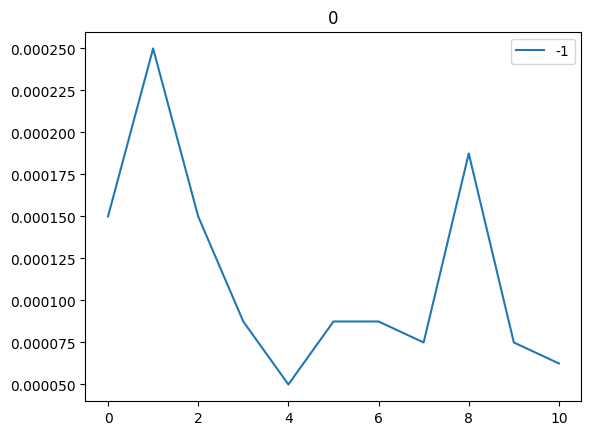

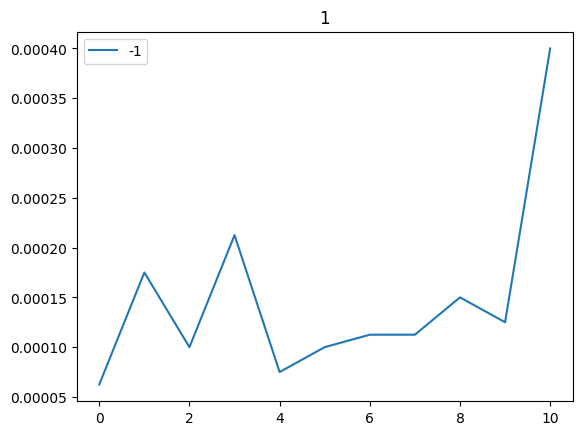

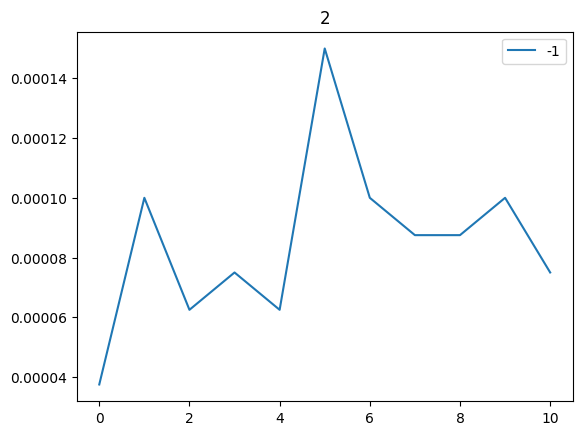

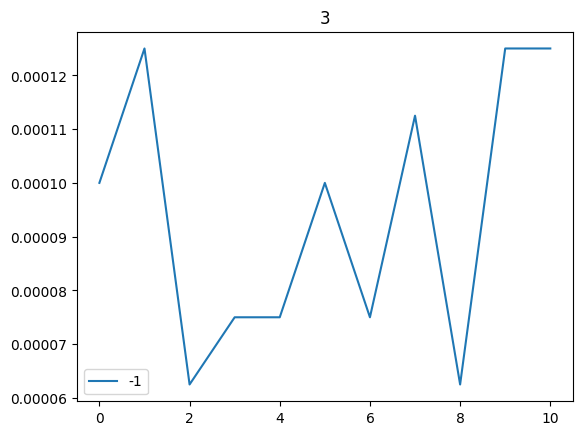

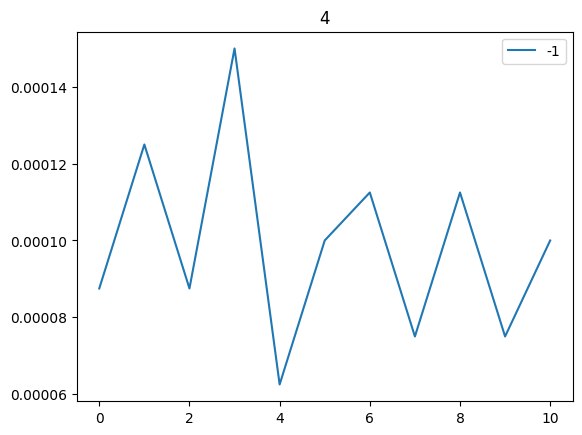

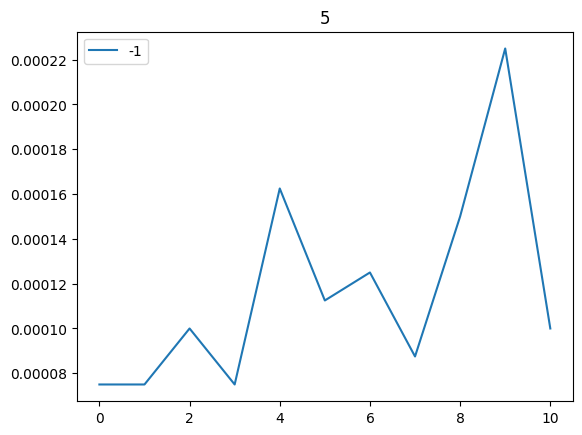

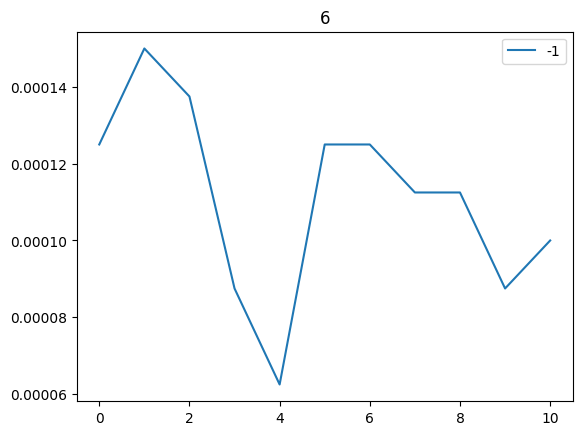

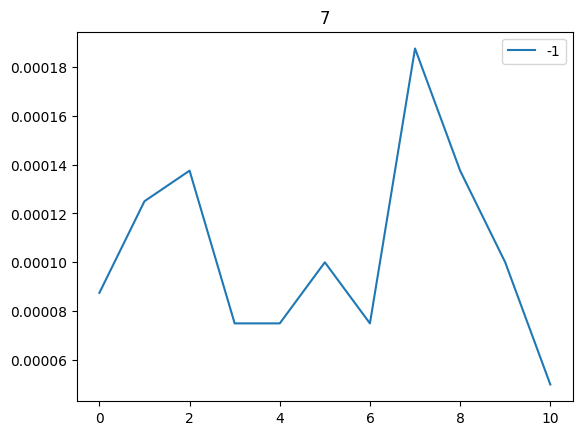

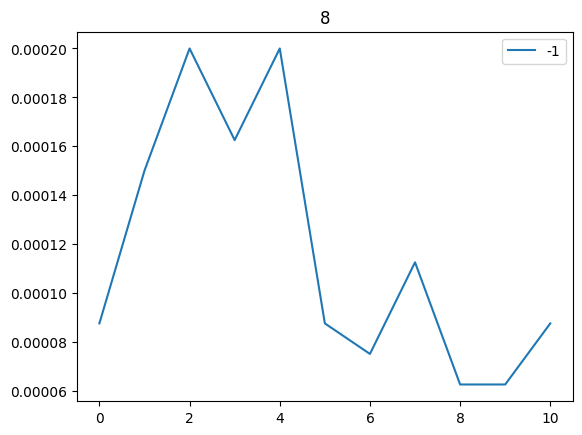

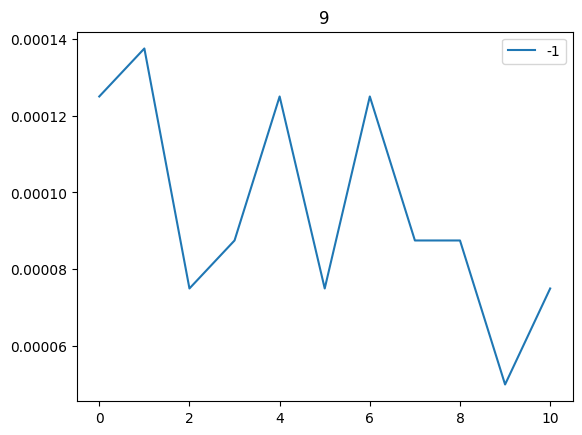

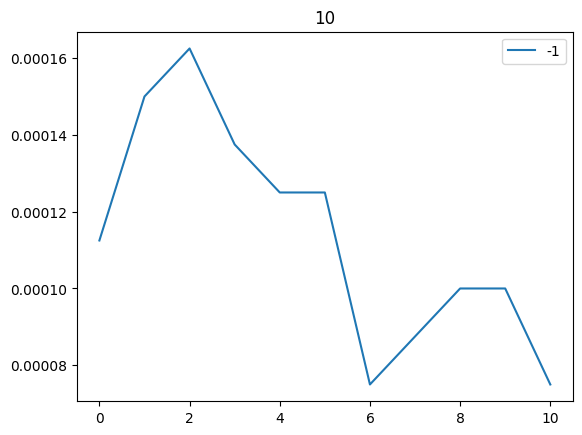

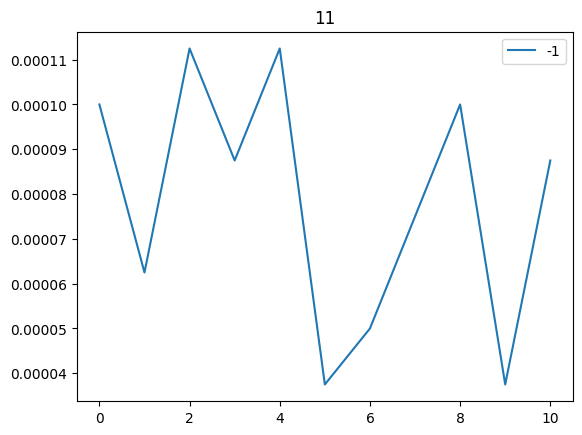

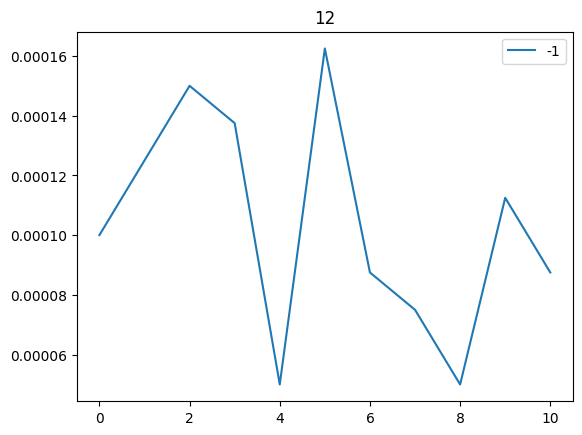

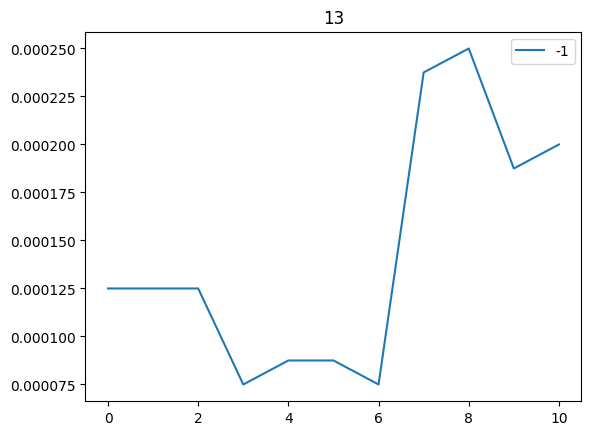

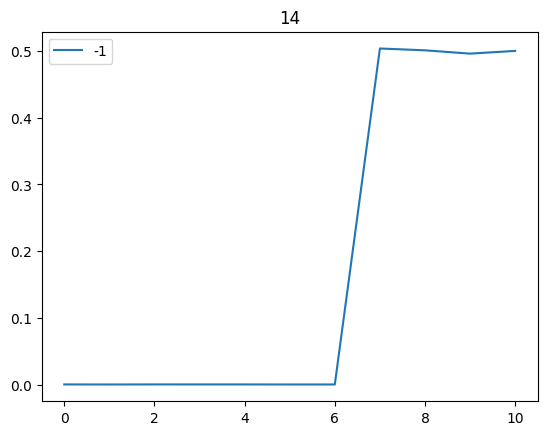

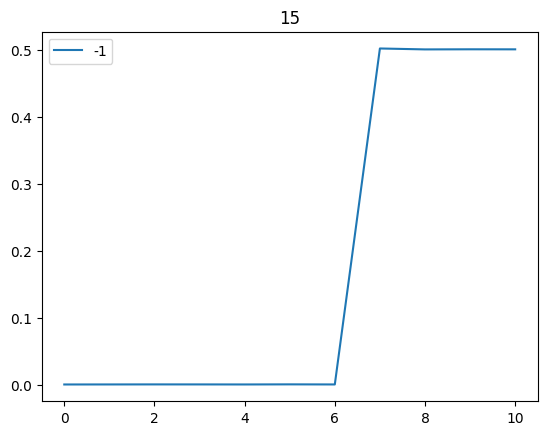

In [8]:
for i, df in enumerate(final_dfs[:16], 0):
    df.plot(title="{}".format(i))
    df.to_pickle('./script7_4_1/{}.pkl'.format(i))

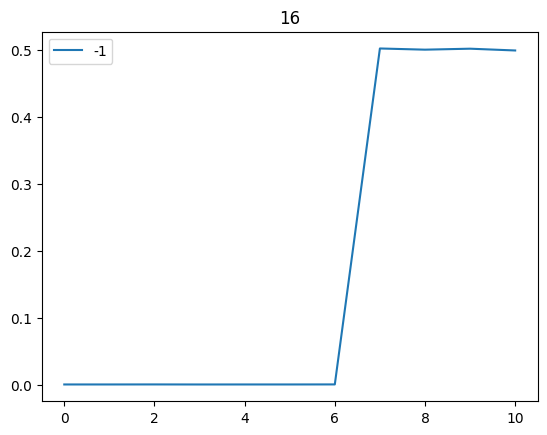

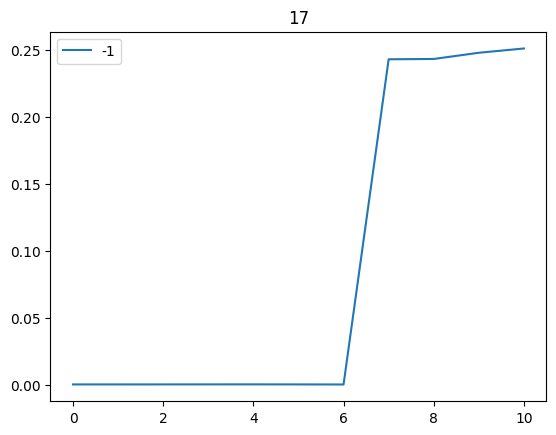

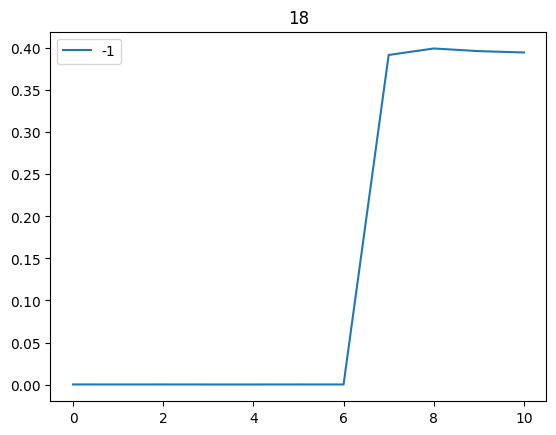

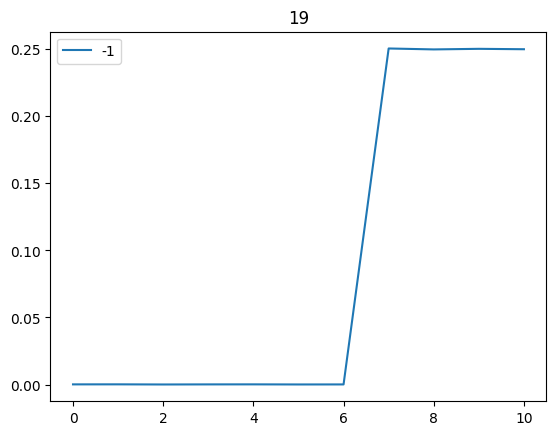

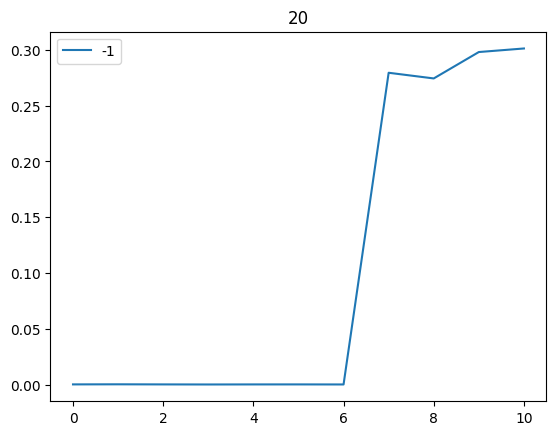

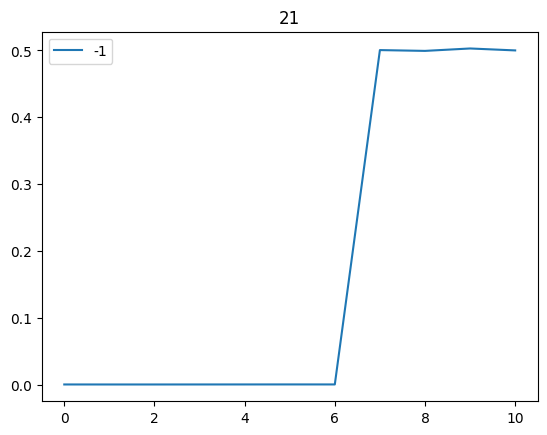

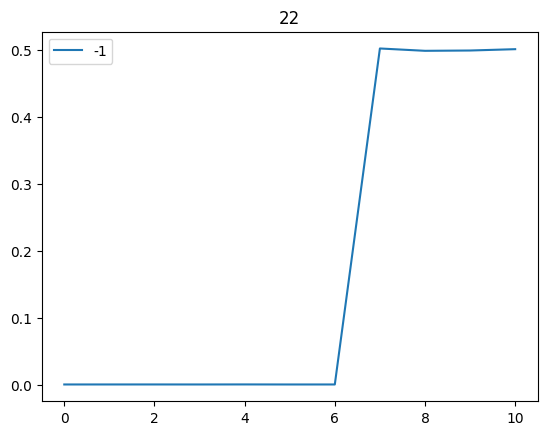

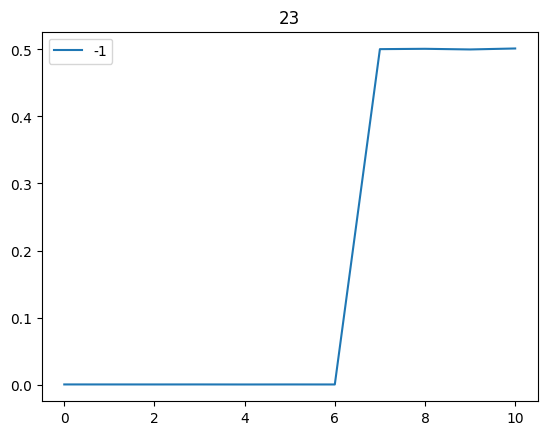

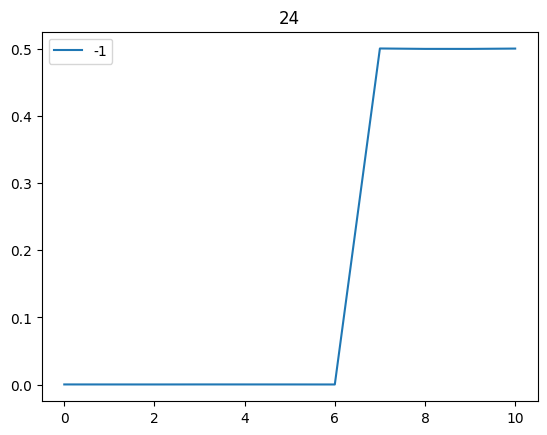

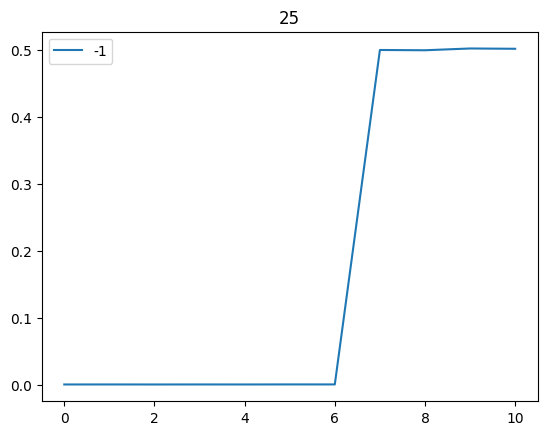

In [9]:
for i, df in enumerate(final_dfs[16:], 16):
    df.plot(title="{}".format(i))
    df.to_pickle('./script7_4_1/{}.pkl'.format(i))